## Imports

In [2]:
import torch
from torch import nn, optim
from torch.autograd import Variable
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F
import torchvision
from torchvision import models, transforms
from torchvision.datasets import ImageFolder
import numpy as np
from collections import OrderedDict
import matplotlib.pyplot as plt
import pickle
from tqdm.notebook import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Loading Data 

In [3]:
data_train_path = 'skin-lesions/train/'
data_valid_path = 'skin-lesions/valid/'
data_test_path = 'skin-lesions/test/'

In [4]:
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p = 0.5),
    transforms.RandomRotation(degrees = 20),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
])

train_dataset = ImageFolder(data_train_path, transform = train_transform)
valid_dataset = ImageFolder(data_valid_path, transform = test_transform)
test_dataset = ImageFolder(data_test_path, transform = test_transform)

train_loader = DataLoader(train_dataset, batch_size = 64, shuffle = True)
valid_loader = DataLoader(valid_dataset, batch_size = 32, shuffle = True)
test_loader = DataLoader(test_dataset, batch_size = 1, shuffle = True)

## Autoencoder

In [5]:
# Creating a DeepAutoencoder class
class DeepAutoencoder(torch.nn.Module):
    def __init__(self):
        super().__init__()        
        self.encoder = torch.nn.Sequential(
            torch.nn.Linear(224 * 224, 256),
            torch.nn.ReLU(),
            torch.nn.Linear(256, 128),
            torch.nn.ReLU(),
            torch.nn.Linear(128, 64),
            torch.nn.ReLU(),
            torch.nn.Linear(64, 10)
        )
          
        self.decoder = torch.nn.Sequential(
            torch.nn.Linear(10, 64),
            torch.nn.ReLU(),
            torch.nn.Linear(64, 128),
            torch.nn.ReLU(),
            torch.nn.Linear(128, 256),
            torch.nn.ReLU(),
            torch.nn.Linear(256, 224 * 224),
            torch.nn.Sigmoid()
        )
  
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

## Train Loop

epoch: 0, loss: 0.7529556676745415
epoch: 1, loss: 0.6165677765384316
epoch: 2, loss: 0.5984637942165136
epoch: 3, loss: 0.5714771598577499
epoch: 4, loss: 0.5649137608706951
epoch: 5, loss: 0.5591293955221772
epoch: 6, loss: 0.5498245479539037
epoch: 7, loss: 0.5487531013786793
epoch: 8, loss: 0.5493664462119341
epoch: 9, loss: 0.5449442723765969
epoch: 10, loss: 0.5448395079001784
epoch: 11, loss: 0.5359474774450064
epoch: 12, loss: 0.5386738991364837
epoch: 13, loss: 0.5322645734995604
epoch: 14, loss: 0.5274380650371313
epoch: 15, loss: 0.5273967506363988
epoch: 16, loss: 0.5332629289478064
epoch: 17, loss: 0.5271862922236323
epoch: 18, loss: 0.5244757290929556
epoch: 19, loss: 0.5169291710481048
epoch: 20, loss: 0.5138125345110893
epoch: 21, loss: 0.5173524571582675
epoch: 22, loss: 0.517375267110765
epoch: 23, loss: 0.5188282150775194
epoch: 24, loss: 0.5133125334978104
epoch: 25, loss: 0.5157816279679537
epoch: 26, loss: 0.5129101146012545
epoch: 27, loss: 0.5102542098611593
epo

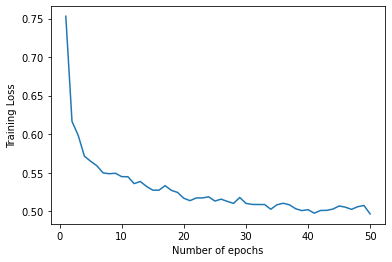

In [5]:
# List that will store the training loss
train_loss = []
  
# Dictionary that will store the
# different images and outputs for 
# various epochs
outputs = {}

# Instantiating the model and hyperparameters
model = DeepAutoencoder().to(device)
criterion = torch.nn.MSELoss()
num_epochs = 50
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
  
batch_size = len(train_loader)
  
# Training loop starts
for epoch in range(num_epochs):
        
    # Initializing variable for storing loss
    running_loss = 0
      
    # Iterating over the training dataset
    for batch in train_loader:
            
        # Loading image(s) and
        # reshaping it into a 1-d vector
        img, _ = batch
        img = img.to(device)
        img = img.reshape(-1, 224*224)
          
        # Generating output
        out = model(img)
          
        # Calculating loss
        loss = criterion(out, img)
          
        # Updating weights according
        # to the calculated loss
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
          
        # Incrementing loss
        running_loss += loss.item()
        
      
    # Averaging out loss over entire batch
    running_loss /= batch_size
    train_loss.append(running_loss)
    
    print(f'epoch: {epoch}, loss: {running_loss}')
      
    # Storing useful images and
    # reconstructed outputs for the last batch
    outputs[epoch+1] = {'img': img, 'out': out}
  
  
# Plotting the training loss
plt.plot(range(1,num_epochs+1),train_loss)
plt.xlabel("Number of epochs")
plt.ylabel("Training Loss")
plt.show()

## Outputs/Results

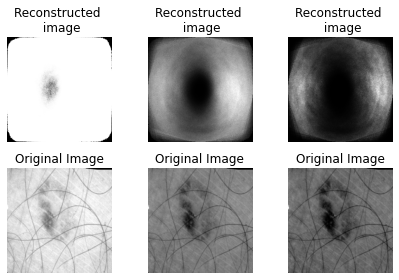

In [6]:
# Dictionary that will store the different
# images and outputs for various epochs
outputs = {}

# Extracting the first batch from the test 
# dataset
img, _ = next(iter(test_loader))

img = img.to(device)

# Reshaping into 1d vector
img = img.reshape(-1, 224 * 224)
  
# Generating output for the obtained
# batch
out = model(img)
  
# Storing information in dictionary
outputs['img'] = img
outputs['out'] = out
  
# Plotting reconstructed images
# Initializing subplot counter
counter = 1
val = outputs['out'].detach().cpu().numpy()
  
# Plotting first 10 images of the batch
for idx in range(3):
    plt.subplot(2, 3, counter)
    plt.title("Reconstructed \n image")
    plt.imshow(val[idx].reshape(224, 224), cmap='gray')
    plt.axis('off')
  
    # Incrementing subplot counter
    counter += 1
    
# Plotting first 10 images
for idx in range(3):
    val = outputs['img'].detach().cpu().numpy()
    plt.subplot(2, 3, counter)
    plt.imshow(val[idx].reshape(224, 224), cmap='gray')
    plt.title("Original Image")
    plt.axis('off')
  
    # Incrementing subplot counter
    counter += 1

plt.tight_layout()
plt.show()

In [7]:
# save_model = open('autoencoder_model.sav', 'wb')
# pickle.dump(model, save_model)
# save_model.close()

torch.save(model.state_dict(), 'autoencoder_upd.pt')

## Converting input images

In [8]:
modified_outputs, labels = [], []
for idx, (sample, target) in enumerate(tqdm(train_dataset, total=len(train_dataset))):
    sample = sample.reshape(-1, 224 * 224)
    out = model(sample.to(device))
    modified_outputs.append(out.cpu().detach().numpy())
    labels.append(target)

  0%|          | 0/2000 [00:00<?, ?it/s]

In [9]:
inputs = np.array(modified_outputs)

In [10]:
inputs = inputs.reshape(inputs.shape[:-1] + (224,224))

In [11]:
data = Variable(torch.from_numpy(inputs))
labels = Variable(torch.from_numpy(np.array(labels)))

In [12]:
train_dataset = TensorDataset(data, labels)

In [13]:
torch.save(train_dataset, 'train_dataset.pt')

In [7]:
model = DeepAutoencoder().to(device)

model.load_state_dict(torch.load('autoencoder_upd.pt'))

<All keys matched successfully>

## More Outputs/Results

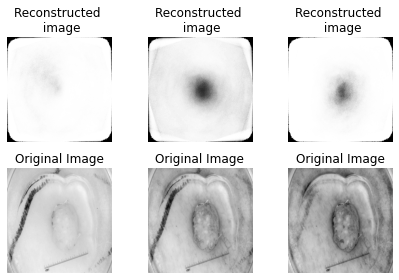

In [10]:
# Dictionary that will store the different
# images and outputs for various epochs
outputs = {}

# Extracting the first batch from the test 
# dataset
img, _ = next(iter(test_loader))

img = img.to(device)

# Reshaping into 1d vector
img = img.reshape(-1, 224 * 224)
  
# Generating output for the obtained
# batch
out = model(img)
  
# Storing information in dictionary
outputs['img'] = img
outputs['out'] = out
  
# Plotting reconstructed images
# Initializing subplot counter
counter = 1
val = outputs['out'].detach().cpu().numpy()
  
# Plotting first 10 images of the batch
for idx in range(3):
    plt.subplot(2, 3, counter)
    plt.title("Reconstructed \n image")
    plt.imshow(val[idx].reshape(224, 224), cmap='gray')
    plt.axis('off')
  
    # Incrementing subplot counter
    counter += 1
    
# Plotting first 10 images
for idx in range(3):
    val = outputs['img'].detach().cpu().numpy()
    plt.subplot(2, 3, counter)
    plt.imshow(val[idx].reshape(224, 224), cmap='gray')
    plt.title("Original Image")
    plt.axis('off')
  
    # Incrementing subplot counter
    counter += 1

plt.tight_layout()
plt.show()

# Updated autoencoder with channels

In [5]:
# Creating a DeepAutoencoder class
class DeepAutoencoder(torch.nn.Module):
    def __init__(self):
        super().__init__()        
        self.encoder = torch.nn.Sequential(
            torch.nn.Linear(224 * 224 * 3, 256),
            torch.nn.ReLU(),
#             torch.nn.Linear(512, 256),
#             torch.nn.ReLU(),
            torch.nn.Linear(256, 128),
            torch.nn.ReLU(),
            torch.nn.Linear(128, 64),
            torch.nn.ReLU(),
            torch.nn.Linear(64, 10)
        )
          
        self.decoder = torch.nn.Sequential(
            torch.nn.Linear(10, 64),
            torch.nn.ReLU(),
            torch.nn.Linear(64, 128),
            torch.nn.ReLU(),
            torch.nn.Linear(128, 256),
#             torch.nn.ReLU(),
#             torch.nn.Linear(256, 512),
            torch.nn.ReLU(),
            torch.nn.Linear(256, 224 * 224 * 3),
            torch.nn.Sigmoid()
        )
  
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

epoch: 0, loss: 0.7452691067010164
epoch: 1, loss: 0.6211174558848143
epoch: 2, loss: 0.593745194375515
epoch: 3, loss: 0.5813559470698237
epoch: 4, loss: 0.5762172527611256
epoch: 5, loss: 0.5696850959211588
epoch: 6, loss: 0.5605001384392381
epoch: 7, loss: 0.5550429560244083
epoch: 8, loss: 0.5506706098094583
epoch: 9, loss: 0.556703289039433


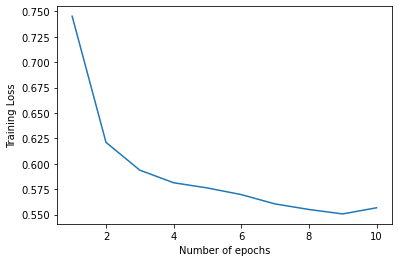

In [6]:
# List that will store the training loss
train_loss = []
  
# Dictionary that will store the
# different images and outputs for 
# various epochs
outputs = {}

# Instantiating the model and hyperparameters
model = DeepAutoencoder().to(device)
criterion = torch.nn.MSELoss()
num_epochs = 10
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
  
batch_size = len(train_loader)
  
# Training loop starts
for epoch in range(num_epochs):
        
    # Initializing variable for storing loss
    running_loss = 0
      
    # Iterating over the training dataset
    for batch in train_loader:
            
        # Loading image(s) and
        # reshaping it into a 1-d vector
        img, _ = batch
        img = img.to(device)
        img = img.reshape(-1, 224*224 * 3)
          
        # Generating output
        out = model(img)
          
        # Calculating loss
        loss = criterion(out, img)
          
        # Updating weights according
        # to the calculated loss
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
          
        # Incrementing loss
        running_loss += loss.item()
        
      
    # Averaging out loss over entire batch
    running_loss /= batch_size
    train_loss.append(running_loss)
    
    print(f'epoch: {epoch}, loss: {running_loss}')
      
    # Storing useful images and
    # reconstructed outputs for the last batch
    outputs[epoch+1] = {'img': img, 'out': out}
  
  
# Plotting the training loss
plt.plot(range(1,num_epochs+1),train_loss)
plt.xlabel("Number of epochs")
plt.ylabel("Training Loss")
plt.show()

In [ ]:
std_error = np.std(train_loss, ddof=1) / np.sqrt(len(train_loss))

ax.errorbar(range(1,num_epochs+1), train_loss,
            yerr=std_error,
            capsize=4)

# plt.plot(range(1,num_epochs+1),train_loss)
plt.xlabel("Number of epochs")
plt.ylabel("Training Loss")
plt.show()

In [7]:
torch.save(model.state_dict(), 'autoencoder_v3.pt')

## Outputs/Results

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(224, 224, 3)


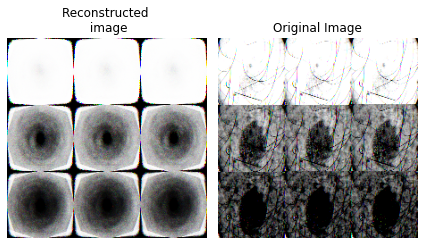

In [61]:
# Dictionary that will store the different
# images and outputs for various epochs
outputs = {}

# Extracting the first batch from the test 
# dataset
img, _ = next(iter(test_loader))

img = img.to(device)

# Reshaping into 1d vector
img = img.reshape(-1, 224 * 224 * 3)
  
# Generating output for the obtained
# batch
out = model(img)
  
# Storing information in dictionary
outputs['img'] = img
outputs['out'] = out
  
# Plotting reconstructed images
# Initializing subplot counter
counter = 1
val = outputs['out'].detach().cpu().numpy()

print(val[0].reshape(224, 224, 3).shape)
plt.figure()
  
plt.subplot(1, 2, counter)
plt.title("Reconstructed \n image")
plt.imshow(val[0].reshape(224, 224, 3))
plt.axis('off')

# Incrementing subplot counter
counter += 1
    
val = outputs['img'].detach().cpu().numpy()
plt.subplot(1, 2, counter)
plt.imshow(val[0].reshape(224, 224, 3))
plt.title("Original Image")
plt.axis('off')

# Incrementing subplot counter
counter += 1

plt.tight_layout()
plt.show()

## Converting training data

In [ ]:
modified_outputs, labels = [], []
for idx, (sample, target) in enumerate(tqdm(train_dataset, total=len(train_dataset))):
    sample = sample.reshape(-1, 224 * 224 * 3)
    out = model(sample.to(device))
    modified_outputs.append(out.cpu().detach().numpy())
    labels.append(target)

In [65]:
inputs = np.array(modified_outputs)

inputs = inputs.reshape(inputs.shape[:-1] + (224,224,3))

data = Variable(torch.from_numpy(inputs))
labels = Variable(torch.from_numpy(np.array(labels)))

train_dataset = TensorDataset(data, labels)

torch.save(train_dataset, 'upd_train_data.pt')